

| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_df  | 캠벨얼리 가격/거래량  |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|


**train accuracy / test accuracy 의 차이 비교 overfitting = 20% 이상 (10~20%)**

https://dacon.io/competitions/official/235801/codeshare/4063?page=1&dtype=recent

[lgbm 튜닝](https://dacon.io/competitions/official/235698/talkboard/404322)

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

/var/folders/08/yfq1rzmx605_pllcn65f77540000gn/T/ipykernel_7283/2031877544.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# iMAC

# raw_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/raw/'
# processed_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/processed/'

In [2]:
# Macbook
    
raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [3]:
submission = pd.read_csv(processed_path+'sample_submission.csv')

print(submission.shape)

(3, 22)


In [6]:
df = pd.read_csv(processed_path+'preprocessing.csv', index_col = 0)
df = df.drop(columns=['월','년'])
df2 = df[:1770]
df_1106 = df[-1:]
df2.shape, df_1106.shape

((1770, 33), (1, 33))

In [9]:
df2 = df2[['date', '요일','대파_거래량(kg)', '대파_가격(원/kg)', '깻잎_거래량(kg)', '깻잎_가격(원/kg)',
       '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)',
       '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)']]
df_1106 = df_1106[['date', '요일','대파_거래량(kg)', '대파_가격(원/kg)', '깻잎_거래량(kg)', '깻잎_가격(원/kg)',
       '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)',
       '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)']]

# LGBM(LightGBM)

## 대파 & 깻잎 & 팽이버섯 & 토마토 & 캠벨얼리

In [40]:
class Nong1:
    

  def __init__(self, df, test):
    self.df = df
    self.test = test
    self.df = pd.concat([self.df, self.test], axis=0).reset_index(drop=True)
    # self.df = self.df[1:].replace(0, np.NaN)
    self.df = self.df.interpolate().fillna(0)
    self.df.date = pd.to_datetime(self.df.date)
    self.df = pd.concat([self.df, pd.get_dummies(self.df['요일'])], axis=1)
    self.feature = self.df.columns[2:]
    self.df = self.df.reset_index(drop=True)

  def set_feature(self,name):
    self.name = name
    self.name1 = name+ "_가격(원/kg)"
    self.name2 = name+ "_거래량(kg)"
    # self.name3 = name+ "_거래량의_1주전_평균"
    # self.name4 = name+ '_가격의_1주전_평균'
    # self.name5 = name+ '_거래량의_2주전_평균'
    # self.name6 = name+ '_가격의_2주전_평균'
    # self.name7 = '계절'
    self.feature = [self.name1, self.name2,'금요일',   '목요일',   '수요일',   '월요일',   '일요일',   '토요일',   '화요일', 'resid'] #  self.name3, self.name4, self.name5, self.name6, self.name7, 

  def set_target(self,week):
    if week == 1:
      self.df['target'] = self.df[self.name1].shift(-8)
    elif week == 2:
      self.df['target'] = self.df[self.name1].shift(-15)
    elif week == 4:
      self.df['target'] = self.df[self.name1].shift(-29)
    
    self.df['resid'] = 0
    stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
    res = stl.fit()
    self.df['resid'] = res.resid.values

  def set_model_lstm(self):
    import tensorflow as tf
    import keras
    from tensorflow.keras import Sequential
    from tensorflow.keras import layers
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    from statsmodels.tsa.seasonal import seasonal_decompose, STL

    # self.scaler = RobustScaler()
    # self.df[self.feature] = self.scaler.fit_transform(self.df[self.feature])
    # self.df_learn = self.df[self.df['target'].notnull()]
    self.X = self.df[self.feature][:-8]
    self.y = self.df['target'][:-8]
    
    self.train_split = -1

    self.X_train = self.X[:self.train_split].values.reshape(-1,1,len(self.feature))
    self.y_train = self.y[:self.train_split].values.reshape(-1,1,1)
    self.X_test = self.X[self.train_split:].values.reshape(-1,1,len(self.feature))
    self.y_test = self.y[self.train_split:].values.reshape(-1,1,1)

    self.model = Sequential()
    self.model.add(layers.Activation('relu'))
    self.model.add(tf.compat.v1.keras.layers.LSTM(100, input_shape=(21,len(self.feature)), return_sequences=True))
    self.model.add(Dropout(0.1))
    self.model.add(layers.Dense(30))
    self.model.add(Dropout(0.1))
    self.model.add(layers.Dense(1))
    self.model.compile(optimizer='adam', loss='mse')
    self.early_stopping = EarlyStopping(patience=30)

    self.model.fit(self.X_train, self.y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[self.early_stopping], verbose=0)

  def get_plot_lstm(self):  
    self.y_pred = self.model.predict(self.X_test)
    print(self.X_test.shape, self.y_pred.shape)
    self.RMSE = mean_squared_error(self.y_test.reshape(-1,1), self.y_pred.reshape(-1,1)) ** 0.5

    plt.figure(figsize=(20, 10), dpi=300)
    plt.title(self.name + ' 가격 예측 결과'+   '   RMSE : ' + str(self.RMSE)[:7])
    plt.ylabel(self.name + ' 가격')
    plt.plot(np.array(self.y_train.reshape(-1,1)), alpha = 0.9, label = 'Real')
    plt.plot(self.model.predict(self.X_train).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
    plt.legend()
    plt.show()
    print(self.RMSE.round(2))

  def get_price_lstm(self):
    # self.X_test = X_test[self.feature]
    self.price = self.model.predict(self.X_test.reshape(-1,1,len(self.feature)))
    return self.price[0][0][0]

In [53]:
my_nong1 = Nong1(df2, df_1106)
# '대파', '깻잎', '팽이버섯', '토마토', '캠벨얼리'
my_nong1.set_feature('팽이버섯')

my_nong1.set_target(1)

In [54]:
my_nong1.set_model_lstm()

(1, 1, 10) (1, 1, 1)


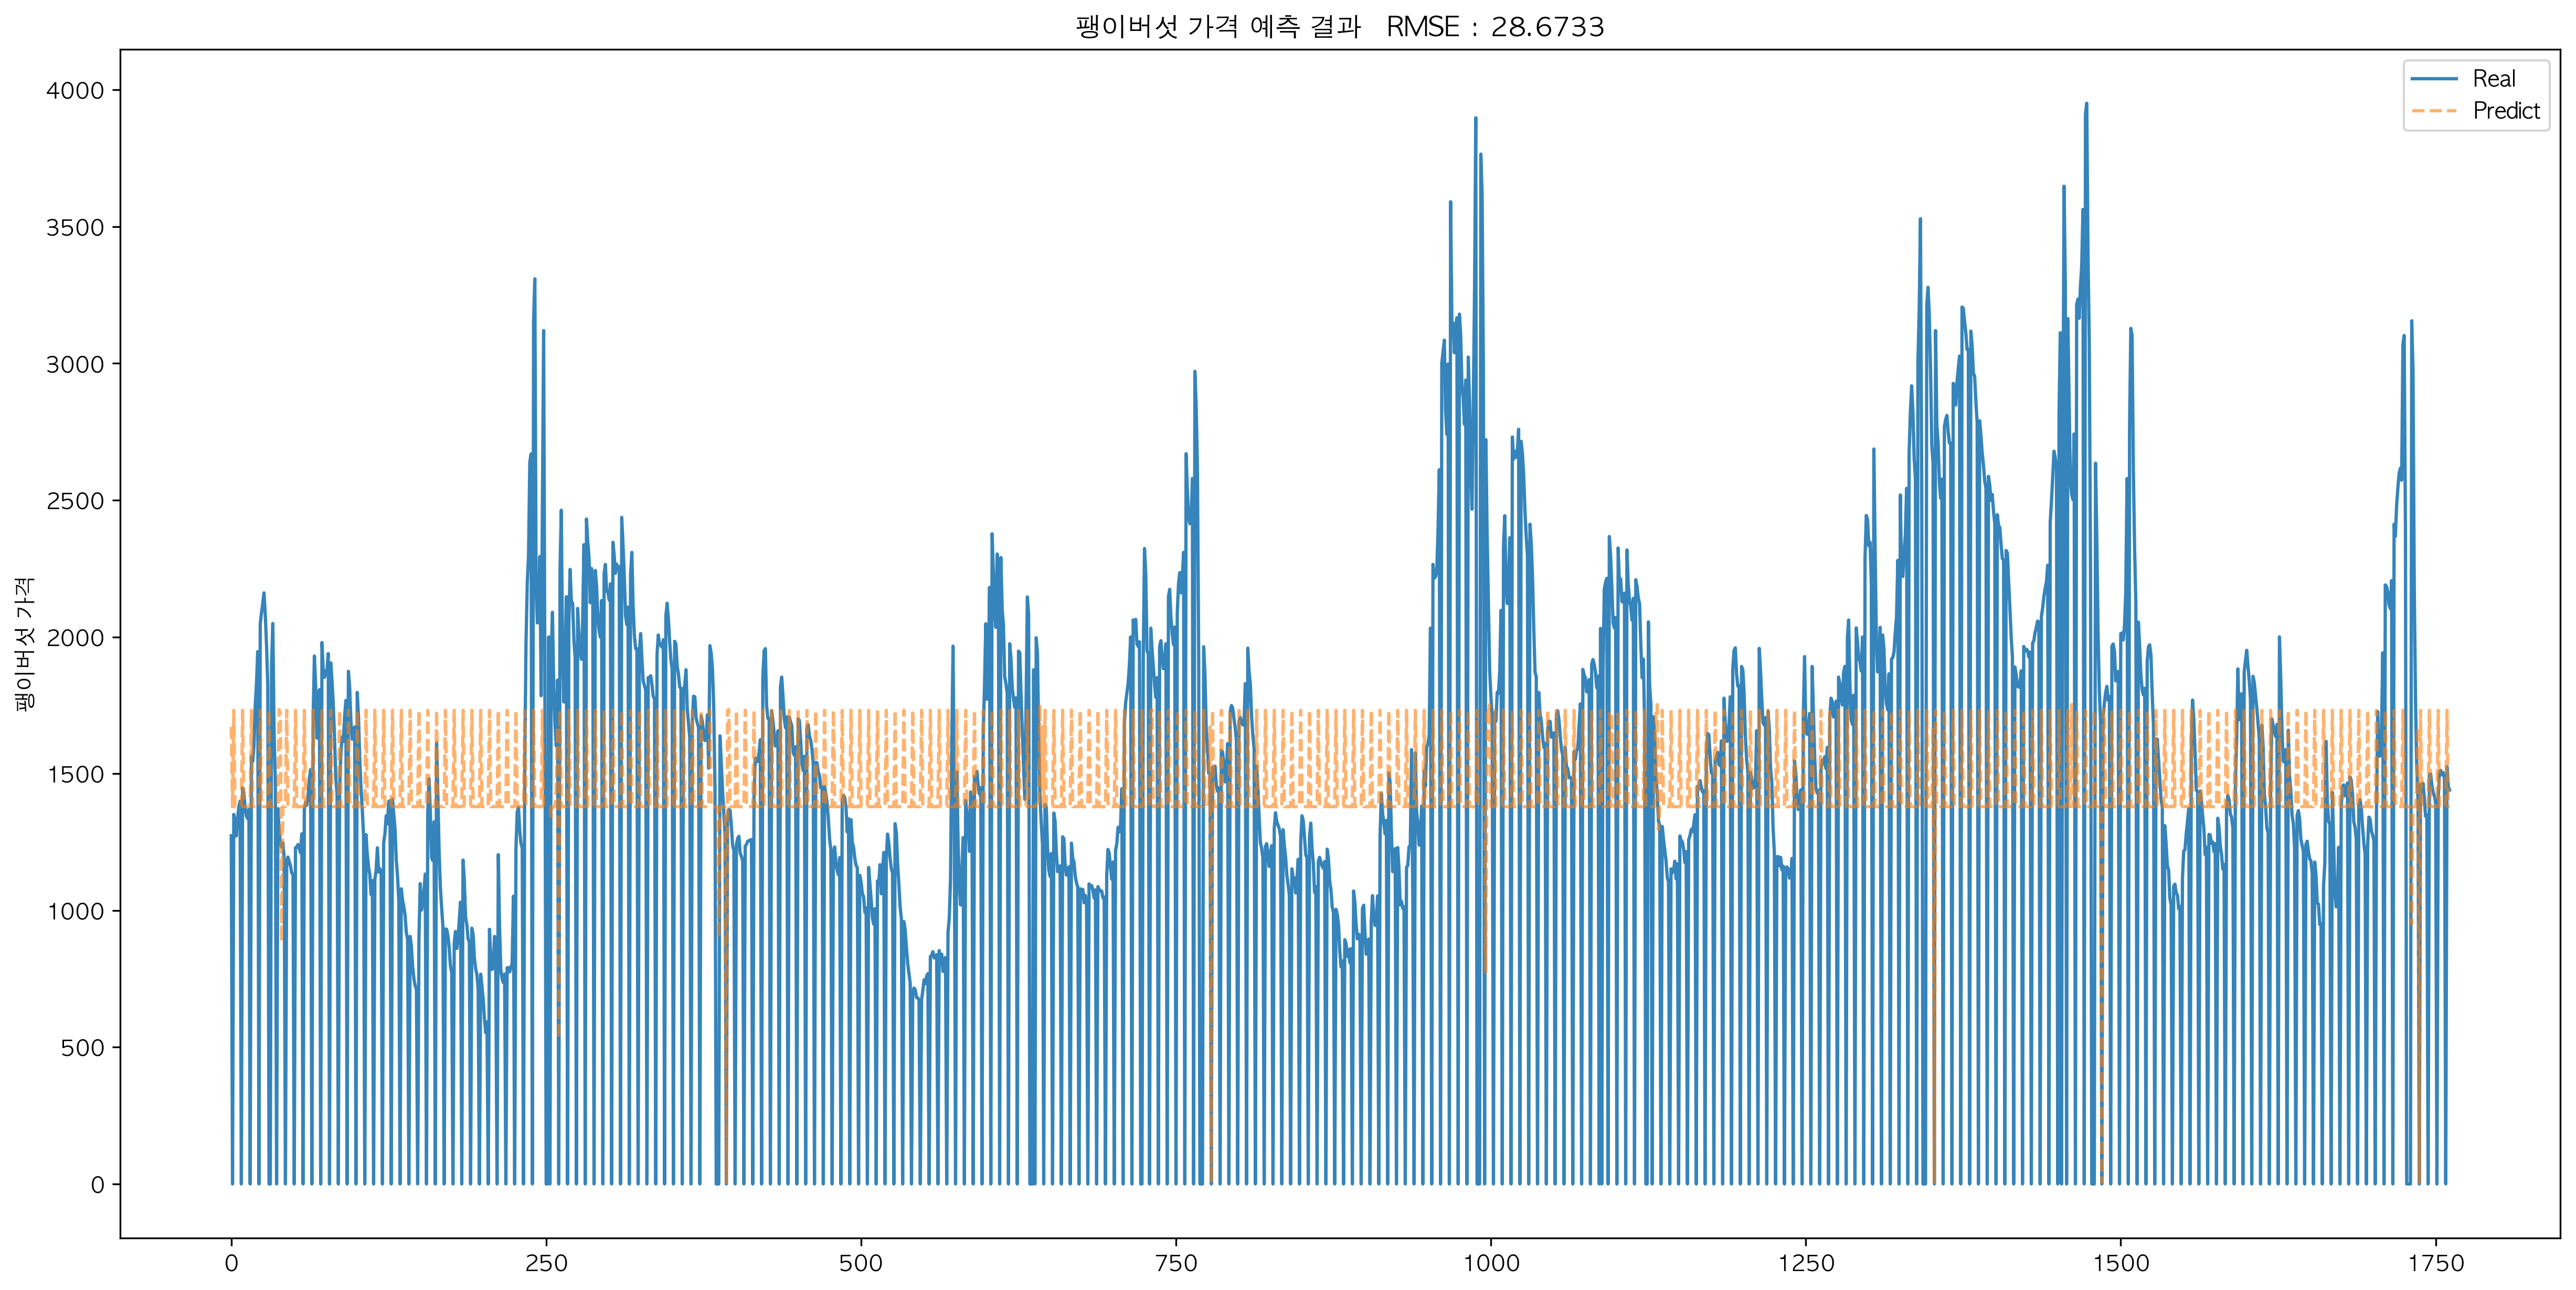

28.67


In [55]:
my_nong1.get_plot_lstm()

In [ ]:
preprocessing = mushroom.copy()
print(preprocessing.shape)
preprocessing.head(2)

(1770, 4)


,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0
1,2016-01-02,토요일,14634.0,1474.0


In [ ]:
preprocessing.describe()

,팽이버섯_거래량(kg),팽이버섯_가격(원/kg)
count,1770.000000,1770.000000
mean,104047.693503,1422.375706
std,47362.202344,806.819552
min,0.000000,0.000000
25%,109714.250000,1071.750000
50%,121313.900000,1454.000000
75%,130855.250000,1918.750000
max,169256.000000,3951.000000


In [ ]:
preprocessing.date = pd.to_datetime(preprocessing.date)
preprocessing['월'] = preprocessing['date'].dt.month 
preprocessing['년'] = preprocessing['date'].dt.year 

# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
preprocessing['계절'] = (preprocessing['월'] // 3 % 4) 
# preprocessing.drop(columns=['월','년'], inplace=True)
print(preprocessing.shape)
preprocessing.head(2)

(1770, 7)


,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg),월,년,계절
0,2016-01-01,금요일,0.0,0.0,1,2016,0
1,2016-01-02,토요일,14634.0,1474.0,1,2016,0


In [ ]:
preprocessing[preprocessing['팽이버섯_가격(원/kg)'] > 3500]

,date,요일,팽이버섯_거래량(kg),팽이버섯_가격(원/kg),월,년,계절
976,2018-09-03,월요일,106437.5,3591.0,9,2018,3
996,2018-09-23,일요일,700.0,3898.0,9,2018,3
1000,2018-09-27,목요일,103954.0,3765.0,9,2018,3
1001,2018-09-28,금요일,125699.0,3620.0,9,2018,3
1349,2019-09-11,수요일,128707.6,3529.0,9,2019,3
1463,2020-01-03,금요일,137634.0,3648.0,1,2020,0
1478,2020-01-18,토요일,114820.0,3563.0,1,2020,0
1480,2020-01-20,월요일,126294.6,3912.0,1,2020,0
1481,2020-01-21,화요일,129463.0,3951.0,1,2020,0


### 1, 2주전 거래량 & 가격 파생변수 생성

In [ ]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 28부터 2015년 12월 31일까지 4일간의 데이터 찾아보자.

A = [];B = []
for x in range(10):
    A.append(0)
    B.append(0)

for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += preprocessing['팽이버섯_거래량(kg)'].iloc[1725 + z]
    t += preprocessing['팽이버섯_가격(원/kg)'].iloc[1725 + z]
v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['팽이버섯_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['팽이버섯_가격의_1주전_평균'])
preprocessing_1 = pd.concat([preprocessing, Adf, Bdf], axis=1)
# preprocessing_1

In [ ]:
# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 농넷에서 찾아야 할 듯 합니다. so 2015년 12월 21부터 2015년 12월 31일까지 11일간의 데이터 찾아보자.

C = [];D = []
for x in range(17):
    C.append(0)
    D.append(0)

for y in range(245):
    s = 0;t = 0
    for z in range(14):
        s += preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(s / (14 - v_1))
        D.append(t / (14 - v_2))
for z in range(14):
    s += preprocessing['팽이버섯_거래량(kg)'].iloc[1718 + z]
    t += preprocessing['팽이버섯_가격(원/kg)'].iloc[1718 + z]
v_1 = (preprocessing['팽이버섯_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (preprocessing['팽이버섯_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(s / (14 - v_1))
D.append(t / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['팽이버섯_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['팽이버섯_가격의_2주전_평균'])
preprocessing_2 = pd.concat([preprocessing_1, Cdf, Ddf], axis=1)
# preprocessing_2

In [ ]:
# 계절 = 0: 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
preprocessing_2.계절.value_counts()

1    460
2    460
3    429
0    421
Name: 계절, dtype: int64

In [ ]:
preprocessing_2.isna().sum()

date                0
요일                  0
팽이버섯_거래량(kg)        0
팽이버섯_가격(원/kg)       0
월                   0
년                   0
계절                  0
팽이버섯_거래량의_1주전_평균    0
팽이버섯_가격의_1주전_평균     0
팽이버섯_거래량의_2주전_평균    0
팽이버섯_가격의_2주전_평균     0
dtype: int64

In [ ]:
# 계절별 평균가격
print(preprocessing_2.loc[preprocessing_2.계절 == 0, '팽이버섯_가격(원/kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 1, '팽이버섯_가격(원/kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 2, '팽이버섯_가격(원/kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 3, '팽이버섯_가격(원/kg)'].mean())

# 계절별 평균거래량
print()
print(preprocessing_2.loc[preprocessing_2.계절 == 0, '팽이버섯_거래량(kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 1, '팽이버섯_거래량(kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 2, '팽이버섯_거래량(kg)'].mean())
print(preprocessing_2.loc[preprocessing_2.계절 == 3, '팽이버섯_거래량(kg)'].mean())

1557.7790973871734
1238.0326086956522
1149.4782608695652
1779.7785547785547

102945.13420427547
110413.1539130435
103169.8615217391
99245.52191142189


In [ ]:
preprocessing_2.columns

Index(['date', '요일', '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '월', '년', '계절',
       '팽이버섯_거래량의_1주전_평균', '팽이버섯_가격의_1주전_평균', '팽이버섯_거래량의_2주전_평균',
       '팽이버섯_가격의_2주전_평균'],
      dtype='object')

## 캠벨얼리, 샤인머스켓 파일저장

In [ ]:
mushroom_preprocessed = preprocessing_2[['date', '요일', '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', 
                           '팽이버섯_거래량의_1주전_평균', '팽이버섯_가격의_1주전_평균', '팽이버섯_거래량의_2주전_평균',
                           '팽이버섯_가격의_2주전_평균','계절']]
mushroom_preprocessed.shape

(1770, 9)

In [ ]:
mushroom_preprocessed.to_csv(processed_path+'팽이버섯_전처리후.csv', index = False)

In [32]:
my_nong1.y_pred, my_nong1.y_test

(array([[[1403.6288]]], dtype=float32), array([[[1408.]]]))

### 모델 실행


In [10]:
# from sympy import Shi

weeks = [1, 2, 4]
features = ['대파', '깻잎', '팽이버섯', '토마토', '캠벨얼리'] 

week1=[]
week2=[]
week4=[]

for week in weeks:
  print(week)
  for feature in features:
    my_nong1 = Nong1(df2, df_1106)
    my_nong1.set_feature(feature)
    my_nong1.set_target(week)
    print(my_nong1.set_target(week))
    my_nong1.set_model_lstm()
    if week == 1:
      week1.append(my_nong1.get_price_lstm())
    if week == 2:
      week2.append(my_nong1.get_price_lstm())
    if week == 4:
      week4.append(my_nong1.get_price_lstm())
    print(feature)

1
None
대파
None
깻잎
None
팽이버섯
None
토마토
None
캠벨얼리
2
None
대파
None
깻잎
None
팽이버섯
None
토마토
None
캠벨얼리
4
None
대파
None
깻잎
None
팽이버섯
None
토마토
None
캠벨얼리


In [17]:
week1, week2, week4

([2229.9282, 4730.3643, 1381.2163, 3677.1748, 2530.5242],
 [1956.2313, 6352.3945, 1449.3448, 3089.8792, 2734.325],
 [1774.1066, 5696.167, 1883.4218, 2235.2224, 2842.737])

In [18]:
from pyrsistent import b

date = '20201106'

feature = [ '대파_가격(원/kg)', '깻잎_가격(원/kg)','팽이버섯_가격(원/kg)', '토마토_가격(원/kg)', '캠벨얼리_가격(원/kg)']
submission = submission.set_index('예측대상일자')
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+1week', feature] = week1
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+2week', feature] = week2
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+4week', feature] = week4
submission.reset_index(drop=False, inplace=True)
title = 'submissionLSTM' + date + '.csv'

In [22]:
submission.drop(columns=['배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)',
       '마늘_가격(원/kg)',  '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)', '파프리카_가격(원/kg)', '새송이_가격(원/kg)', 
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)','샤인마스캇_가격(원/kg)'], inplace= True)

In [23]:
submission2 = submission.round(2)
submission2 = submission2[3:]
submission2

,예측대상일자,대파_가격(원/kg),깻잎_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),캠벨얼리_가격(원/kg)
3,2020-11-06+1week,2229.93,4730.36,1381.22,3677.17,2530.52
4,2020-11-06+2week,1956.23,6352.39,1449.34,3089.88,2734.32
5,2020-11-06+4week,1774.11,5696.17,1883.42,2235.22,2842.74


In [24]:
# 실제값과 비교!
private2 = pd.read_csv(raw_path+'private_data.csv')
private2 = private2[['date','요일','대파_가격(원/kg)', '깻잎_가격(원/kg)','팽이버섯_가격(원/kg)', '토마토_가격(원/kg)', '캠벨얼리_가격(원/kg)']]
private2_week = private2[::7]
private2_week[0:5]

,date,요일,대파_가격(원/kg),깻잎_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),캠벨얼리_가격(원/kg)
0,2020-11-06,금요일,2402.0,4831.0,1408.0,2806.0,2797.0
7,2020-11-13,금요일,2374.0,5013.0,1532.0,2305.0,3579.0
14,2020-11-20,금요일,2319.0,3316.0,1471.0,2015.0,4859.0
21,2020-11-27,금요일,1841.0,3129.0,1294.0,1847.0,4353.0
28,2020-12-04,금요일,1543.0,4326.0,1255.0,1814.0,4063.0


In [25]:
submission2.to_csv(processed_path + title, encoding='utf-8-sig', index = False)